# 1.들어가기 전에

마법 공식을 통해 s&p 500의 기업들을 추려서 그래도 분석하고자 하였으나, 
그보다는 마법 공식을 어느정도 따르면서 규모가 큰 회사들을 선택해서 예시를 보여주는 것이 더 좋다는 결론이 나서 
그런 식으로 프로젝트를 진행했습니다.

In [1]:
import pandas as pd 
import pandas_datareader as pdr
import talib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler

In [2]:


import numpy as np
import tensorflow as tf
import random as python_random

seed_number = 7
np.random.seed(seed_number)
python_random.seed(seed_number)
tf.set_random_seed(seed_number) # v1
# tf.random.set_seed(seed_number) # v2

AttributeError: module 'tensorflow' has no attribute 'set_random_seed'

## DataLoad

In [9]:
# 1.먼저 데이터를 로드 한다.
#2. 이 때, df에는 intc(인텔), google, apple등의 파일을 돌아가면서 로드한다.
#그래야 기업별  lstm의 효과를 볼 수 있기 때문이다.
df = pd.read_csv('intc.csv',
                 index_col='Date',
                 parse_dates=True)
sox_df = pd.read_csv('sox_df.csv',
                     index_col='Date',
                     parse_dates=True)
vix_df = pd.read_csv('vix_df.csv',
                     index_col='Date',
                     parse_dates=True)
snp500_df = pd.read_csv('s&p500.csv',
                        index_col='Date',
                        parse_dates=True)

## Data Features

In [10]:
#2.데이터 가공/결합하는 단계
#기술 지표는 책: 퀀트 전략을 위한 인공지능 트레이딩의 3장에 있다.
#talib을  이용하면 기술 지표를 쉽게 만들 수 있다.

df['next_price'] = df['Adj Close'].shift(-1)
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA : Standard deviation rolling average
# 이동 평균
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd 

# 모멘텀 지표
#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
# Volatility Indicators 

#4.ATR : Average True Range
#변동성 지표
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL : Bollinger Band
#볼린저 밴드
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1 
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [11]:
#3.이렇게 가공된 데이터프레임 옆에 시장 지수 데이터를 추가한다.
#시장 지수 또한 주식에 모델러의 인사이트를 반영한 데이터라고 볼 수 있다.

In [ ]:
snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'},inplace=True)
sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'},inplace=True)
vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'},inplace=True)

df = df.join(snp500_df,how='left') #미리 가공한 데이터프레임에 left join 해서 같이 사용할 수 있도록 한다.
df = df.join(sox_df,how='left')
df = df.join(vix_df,how='left')

In [14]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_price,next_rtn,log_return,CCI,...,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,41.9375,40.96875,41.906250,41.15625,11572000.0,26.504349,28.013699,-0.017897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1469.250000,704.559998,24.639999
2000-01-03,43.6875,41.62500,41.632812,43.50000,57710200.0,28.013699,26.705585,0.044849,0.055385,NaN,...,NaN,NaN,NaN,2.34375,NaN,NaN,NaN,1455.219971,713.200012,24.209999
2000-01-04,43.9375,41.12500,42.718750,41.46875,51019600.0,26.705585,26.926966,-0.029261,-0.047821,NaN,...,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN,1399.420044,687.320007,27.010000
2000-01-05,42.9375,40.25000,41.500000,41.81250,52389000.0,26.926966,25.357227,0.007530,0.008255,NaN,...,NaN,NaN,NaN,0.34375,0.65625,NaN,NaN,1402.109985,678.539978,26.410000
2000-01-06,41.6875,39.09375,40.875000,39.37500,55171200.0,25.357227,26.403713,-0.036697,-0.060064,NaN,...,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN,1403.449951,669.330017,25.730000


In [15]:
#4. 분석을 위한 변수가 모두 포함된 데이터프레임이 모두 준비되었다. 이제 위 데이터의 학습/검증/ 테스트 데이터셋을 구간별로 나눠보자.
# feature list
# feature_list = ['Adj Close', 'log_return', 'CCI','next_price']
# 볼린저 밴드와 MACD를 어떻게 활용해야할까? 음. 아님 그냥 그대로 사용하는 건가?
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['S&P500', 'SOX', 'VIX']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']

all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [16]:
phase_flag = '3' # 기존 책에 있던 것 보다 데이터 기간을 더 늘렸습니다. (1년씩 더 늘렸습니다.)

if phase_flag == '1' :
    train_from = '2010-01-04'
    train_to = '2013-01-01'

    val_from = '2012-01-01'
    val_to = '2013-04-01'

    test_from = '2012-04-01'
    test_to = '2013-07-01'

elif phase_flag == '2' :
    train_from = '2013-07-01'
    train_to = '2015-07-01'

    val_from = '2015-07-01'
    val_to = '2016-10-01'

    test_from = '2015-10-01'
    test_to = '2016-01-01'
    
else : 
    train_from = '2016-01-01'
    train_to = '2018-01-01'

    val_from = '2018-01-01'
    val_to = '2019-04-01'

    test_from = '2018-04-01'
    test_to = '2019-07-01'

In [17]:
#5.기간을 각각 어떻게 나누었는지 잘 살펴보자. 기간을 각각 어떻게 나누었는가에 따라 결과가 달라질 수 있다.
# train / validation / testing
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [18]:
train_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,33.880001,34.009998,33.459999,30.453503,27882200.0,-0.013443,0.303052,0.396672,35.563334,33.937667,...,34.760001,34.662000,-0.459999,-1.449997,5.167085,-75.117262,2012.660034,656.280029,20.700001,0.003247
2016-01-05,33.959999,34.000000,33.529999,30.310141,16709500.0,-0.004719,0.367040,0.404861,35.595366,33.794635,...,34.540001,34.658001,-0.160000,-1.160000,4.028294,-82.628988,2016.709961,649.469971,19.340000,-0.003828
2016-01-06,33.250000,33.520000,32.799999,29.638180,25491300.0,-0.022419,0.448109,0.413248,35.730171,33.468830,...,34.068002,34.542001,-0.750000,-1.369999,2.924712,-89.964068,1990.260010,631.200012,20.590000,-0.005113
2016-01-07,32.279999,33.009998,31.840000,28.527191,37680500.0,-0.038206,0.593121,0.454210,36.100868,32.807133,...,33.438001,34.253001,-1.240002,-2.150002,-1.148708,-100.000000,1943.089966,610.250000,24.990000,-0.013631
2016-01-08,32.090000,32.220001,31.430000,28.231529,29953800.0,-0.010418,0.732896,0.512523,36.365380,32.212620,...,32.850001,33.904001,-0.330000,-2.320002,-1.654184,-98.076925,1922.030029,600.479980,27.010000,-0.018074


In [ ]:
#6.다음은 데이터 전처리의 마지막 단계인 정규화이다. 여러가지 방법중 최대/최소 정규화가 있다.
#이 때, MinMaxScaler을 사용한다.

In [26]:
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue #생략.
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # 스캐일러 생성,훈련
        scaler = MinMaxScaler(feature_range=(0, 1)) #생성
        scaler = scaler.fit(values) #훈련
#         print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # 데이터셋 정규화, 훈련
        normalized = scaler.transform(values) #입력 데이터를 최소-최대 정규화한다.
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized #정규화된 데이터를 새로운 컬럼명으로 저장한다.
    return sample_df, eng_list

In [27]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [28]:
train_sample_df.head()
#이름 뒤에 ....normal이 붙은 것이 바로 정규화가 된 것이다.

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,33.880001,34.009998,33.459999,30.453503,27882200.0,-0.013443,0.303052,0.396672,35.563334,33.937667,...,0.395493,0.339590,0.332878,0.417911,0.233197,0.456961,0.248827,0.213197,0.124088,0.608421
2016-01-05,33.959999,34.000000,33.529999,30.310141,16709500.0,-0.004719,0.367040,0.404861,35.595366,33.794635,...,0.372752,0.327586,0.332650,0.467662,0.272977,0.433660,0.173710,0.217901,0.115385,0.536842
2016-01-06,33.250000,33.520000,32.799999,29.638180,25491300.0,-0.022419,0.448109,0.413248,35.730171,33.468830,...,0.337430,0.301833,0.326047,0.369818,0.244170,0.411081,0.100359,0.187184,0.092037,0.602632
2016-01-07,32.279999,33.009998,31.840000,28.527191,37680500.0,-0.038206,0.593121,0.454210,36.100868,32.807133,...,0.281369,0.267460,0.309597,0.288557,0.137174,0.327737,0.000000,0.132404,0.065264,0.834211
2016-01-08,32.090000,32.220001,31.430000,28.231529,29953800.0,-0.010418,0.732896,0.512523,36.365380,32.212620,...,0.230654,0.235378,0.289731,0.439469,0.113855,0.317394,0.019231,0.107946,0.052779,0.940526


### LSTM Model 훈련데이터 구분하기

7.다음 코드는 학습에 사용하는 데이터와 레이블 데이터를 나눈다.
목표는 다음 영업일 종가 예측이다. 현재 데이터셋에는 레이블링된 데이터가 같이 있으므로 이를 구분하기 위해 
데이터를 나눌 필요가 있다.

In [29]:
num_step = 5
num_unit = 200

In [30]:
def create_dateset_binary(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]]) #우리가 사용할 lstm 모델에 넣어줄 변수 데이터를 선택한다.
    
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step) #마지막 단계를 설정한다.
    #     np.random.shuffle(m)  # shufflee은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)] #각 단계마다 사용할 학습 데이터 기간을 정해준다. 얼마만큼의 과거으 데이터 기간을 입력으로 전달할지 정의한다.
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n)) #신경망에 사용할 수 있게 데이터를 정리한다.
    
    train_ydata = np.array(data[[feature_list[n]]]) #레이블링 데이터를 만든다.
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1
        else :
            label = 0
        y.append(label)
    y_batch = np.reshape(np.array(y), (-1,1)) #학습을 위한 1차원 열 백터 형태로 바꾼다.
    return x_batch, y_batch

In [31]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1
# LSTM할때 사용했던 소스코드.
x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature) #훈련 데이터에 대한 변수 데이터와 레이블 데이터를 나눈다.
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature) #검증 데이터에 대한 변수 데이터/레이블 데이터를 나눈다.
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature) #테스트 데이터에 대한 변수 데이터/레이블 데이터를 나눈다.

In [32]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [33]:
print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    223.0
1    275.0
dtype: float32
0    146.0
1    162.0
dtype: float32
0    150.0
1    160.0
dtype: float32


### 모델을 수정해보자 Keras로 

In [36]:
x_train.shape
#8.1개의 시점에 22개의 변수를 적용하고, 5일 데이터로 1step을 학습하는데, 이게 1묶음이다.
#그 묶음이 498개가 있다.

(498, 5, 22)

In [37]:
#9.keras에 대한 클래스를 임포트한다.
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [41]:
# 10.LSTM 모델을 생성한다.
#총 5개의 lstm 층과 200개의 뉴런을 사용해 모델링한다. 또한, L2정규화 방법을 각 층에 적용한다.
#더 높은 정확도를 얻고 싶다면, 이 부분을 수정해 보는 것도 좋다.
#사이사이에 dropout, BatchNormalization을 넣어 과적합을 방지하고, 정규화를 통해 네트워크 학습이 잘 일어나도록 돕는 방식이다.
K.clear_session()
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2])) #입력 데이터셋의 형태에 맞게 값을 지정한다. 우리는 3차원 배열을 넣는다.
#첫번째가 NONE인 이유는 뒤에 뭐든 와도 좋기 때문이며, 두번째와 세번째는 각각 5와 22를 넣는다.
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2) #Dropout을 이어 임의의 확률로 가중치의 선을 지운다. 이를 통해 과적합을 방지한다.
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5) #이런 식으로 층을 쌓아간다. 
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5) #최종 예측값을 뽑도록 한다. 이때 , dense 함수가 쓰인다.

model = Model(input_layer, output_layer) #모델을 생성한다.
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) #모델 학습 방식을 결정한다.

In [42]:
#11.모델의 요약 정보를 확인한다.
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 200)            178400    
                                                                 
 batch_normalization (Batch  (None, 5, 200)            800       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 5, 200)            320800    
                                                                 
 dropout (Dropout)           (None, 5, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 200)            320800    
                                                             

https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/
이 말인 즉슨 LSTM이 자체 gate 별 활성화 함수를 갖고있다.

In [262]:
y_val.shape

(308, 2)

In [43]:
#11.모델 학습
history = model.fit(x_train,y_train,epochs=70, batch_size=15, validation_data=(x_val, y_val))

Epoch 1/70
34/34 [==============================] - 16s 99ms/step - loss: 7.3926 - accuracy: 0.5241 - val_loss: 4.1223 - val_accuracy: 0.5260
Epoch 2/70
34/34 [==============================] - 1s 37ms/step - loss: 3.0832 - accuracy: 0.5281 - val_loss: 2.0512 - val_accuracy: 0.5260
Epoch 3/70
34/34 [==============================] - 1s 37ms/step - loss: 1.7511 - accuracy: 0.5462 - val_loss: 1.3331 - val_accuracy: 0.5260
Epoch 4/70
34/34 [==============================] - 1s 37ms/step - loss: 1.2041 - accuracy: 0.5522 - val_loss: 1.0267 - val_accuracy: 0.5260
Epoch 5/70
34/34 [==============================] - 1s 37ms/step - loss: 0.9935 - accuracy: 0.5522 - val_loss: 0.8855 - val_accuracy: 0.5260
Epoch 6/70
34/34 [==============================] - 1s 38ms/step - loss: 0.8960 - accuracy: 0.5582 - val_loss: 0.8152 - val_accuracy: 0.5032
Epoch 7/70
34/34 [==============================] - 1s 39ms/step - loss: 0.8315 - accuracy: 0.5442 - val_loss: 0.7844 - val_accuracy: 0.4870
Epoch 8/70
3

Epoch 59/70
34/34 [==============================] - 1s 40ms/step - loss: 0.6803 - accuracy: 0.6225 - val_loss: 0.8936 - val_accuracy: 0.4188
Epoch 60/70
34/34 [==============================] - 1s 39ms/step - loss: 0.6759 - accuracy: 0.6305 - val_loss: 0.8819 - val_accuracy: 0.4740
Epoch 61/70
34/34 [==============================] - 1s 39ms/step - loss: 0.6862 - accuracy: 0.5884 - val_loss: 0.8892 - val_accuracy: 0.4545
Epoch 62/70
34/34 [==============================] - 1s 39ms/step - loss: 0.6695 - accuracy: 0.5904 - val_loss: 0.9851 - val_accuracy: 0.4545
Epoch 63/70
34/34 [==============================] - 1s 39ms/step - loss: 0.6667 - accuracy: 0.6024 - val_loss: 1.0674 - val_accuracy: 0.4156
Epoch 64/70
34/34 [==============================] - 1s 38ms/step - loss: 0.6855 - accuracy: 0.6165 - val_loss: 0.9694 - val_accuracy: 0.4578
Epoch 65/70
34/34 [==============================] - 1s 38ms/step - loss: 0.6868 - accuracy: 0.5984 - val_loss: 1.0957 - val_accuracy: 0.4318
Epoch 

In [45]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

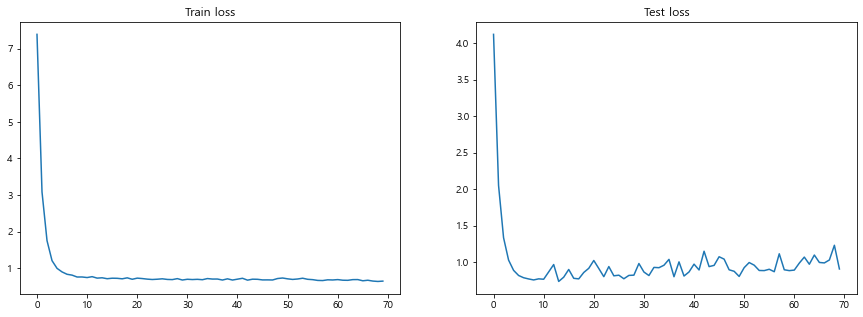

In [46]:
plot_history(history) 
#12.학습 결과, 손실값은 떨어지다가 일정한 값을 유지하고, 검증 데이터의 손실 또한 안정되는 것을 확인할 수 있다.

In [27]:
# model.save('model_functional_open_close_binary_phase3.h5')

## 예측

13.학습된 모델로 예측값을 만들어보자. 잘 예측하는지 알아보기 위해 평가 지표를 사용해 평가한다.

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [49]:
predicted = model.predict(x_test) #테스트 데이터로 모델의 예측값을 출력한다.
y_pred = np.argmax(predicted, axis=1) 
Y_test = np.argmax(y_test, axis=1)#원-핫 인코딩으로 되어 있는 예측값과 실제 레이블 데이터를 다른 범주로 바꾼다.
cm = confusion_matrix(Y_test, y_pred)#사이킷런에서 사용하는 혼동 행렬 함수를 호출한다.
report = classification_report(Y_test, y_pred) #더 많은 수치를 계한하는 리포트 함수를 호출한다.

10/10 [==============================] - 0s 24ms/step


## ROC AUC 커브 만들어보기.

14.이 함수들을 통해 roc auc 커브를 만들 수 있다.
간단히 이야기해서, auc는 그래프의 아랫 부분이라고 볼 수 있는데, 이 값이 클수록 성능이 좋은 것이다.

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

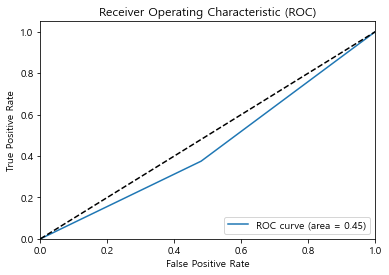

ROC AUC 값 : 0.4475


In [55]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

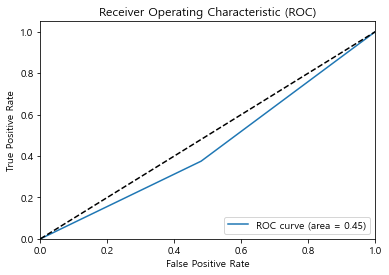

ROC AUC 값 : 0.4475


In [56]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

## Drop & Batch

In [57]:
y_pred # 3단계

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [58]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)

f_output = open('binary_lstm_open_close_phase3_dropout_batch_Normal_3단계 test.txt', 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch\n'.format(
    20, 10))
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

In [59]:
# 예측.
# y_hat = model.predict(x_test, batch_size = 1)
print(len(y_test))
print(len(y_pred))

310
310


<AxesSubplot:xlabel='Date'>

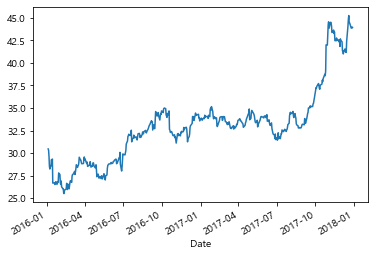

In [60]:
train_sample_df['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

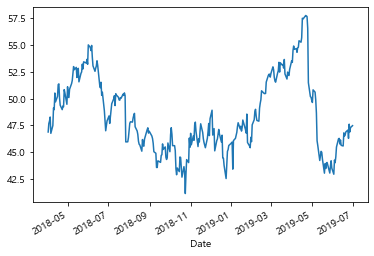

In [61]:
test_sample_df['Adj Close'].plot()

In [277]:
# 3단계 
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

<AxesSubplot:xlabel='Date'>

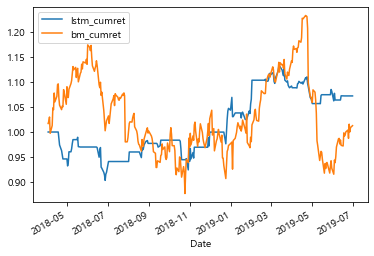

In [278]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

<AxesSubplot:xlabel='Date'>

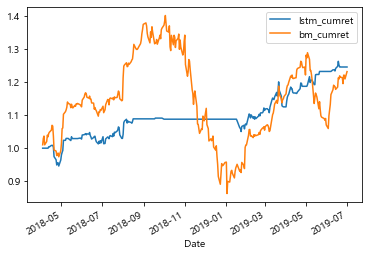

In [193]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

# 15. backtesting과 lstm의 정확도 차이 구분.

backtesting을 할 때의 cacr(이익률)과 lstm을 이용할 때의 cacr의 차이를 잘 보도록 하자


# Backtesting

<AxesSubplot:xlabel='Date'>

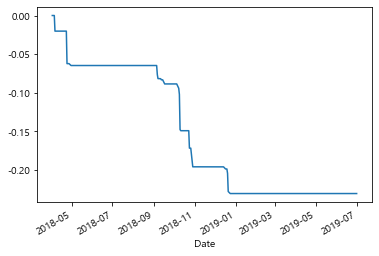

In [237]:
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

## BM

In [279]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  1.01 %
Sharpe :  0.19
VOL :  30.17 %
MDD :  23.03 %


## LSTM

## INTEL 결과

In [280]:
# epochs=70, batch_size=15 으로 설정하고 돌렸습니다. 
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  5.71 %
Sharpe :  0.46
VOL :  14.3 %
MDD :  23.03 %


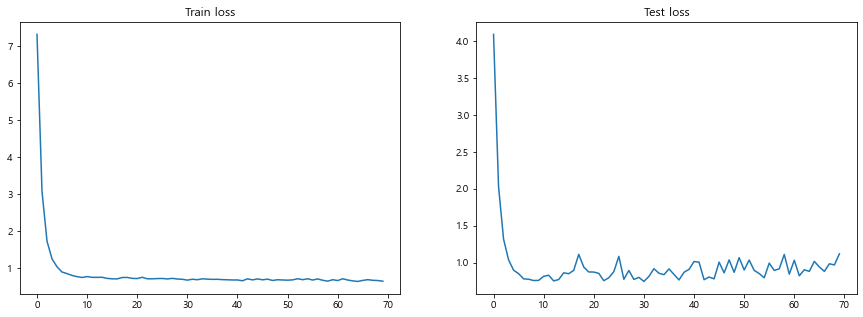

In [281]:
plot_history(history) # 3단계

<AxesSubplot:xlabel='Date'>

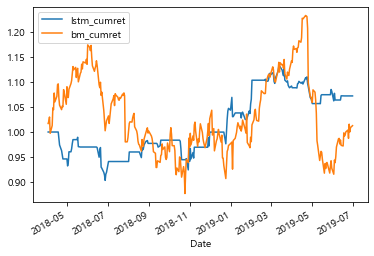

In [282]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

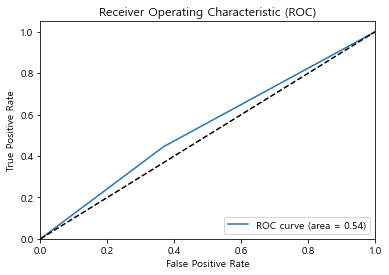

ROC AUC 값 : 0.5385


In [283]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

## Alphabet(google) 결과

In [238]:
# epochs=70, batch_size=15 으로 설정하고 돌렸습니다. 
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  13.65 %
Sharpe :  0.88
VOL :  16.01 %
MDD :  23.03 %


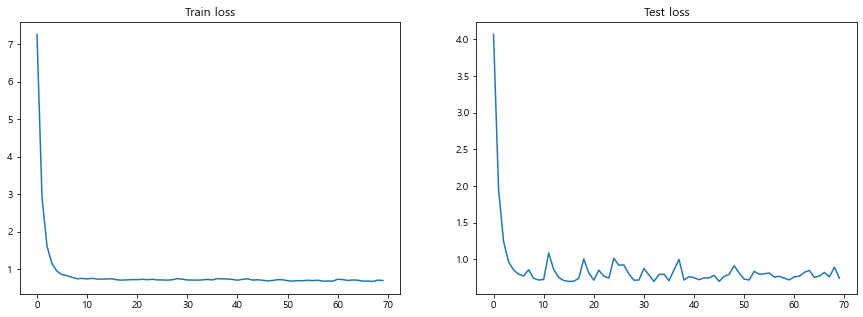

In [239]:
plot_history(history) # 3단계

<AxesSubplot:xlabel='Date'>

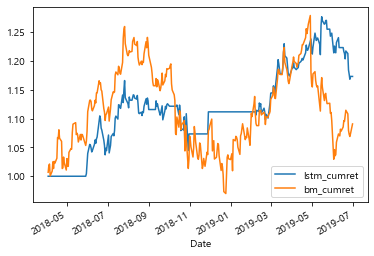

In [241]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

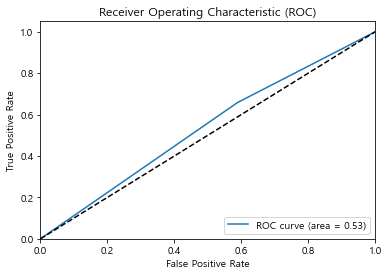

ROC AUC 값 : 0.5346


In [240]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

## APPLE 결과

In [196]:
# epochs=70, batch_size=15 으로 설정하고 돌렸습니다. 
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  19.26 %
Sharpe :  1.62
VOL :  11.3 %
MDD :  38.52 %


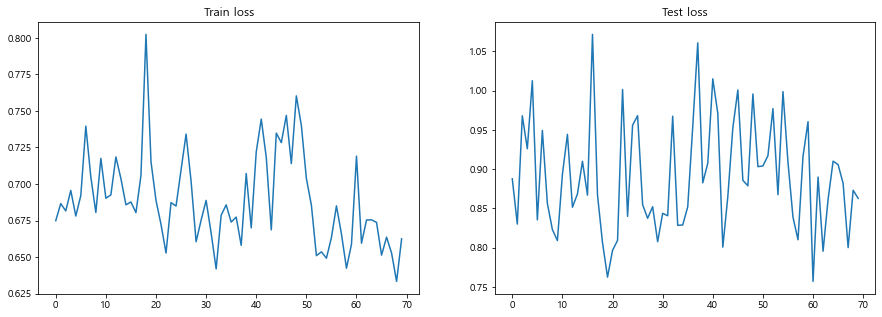

In [198]:
plot_history(history) # 3단계

<AxesSubplot:xlabel='Date'>

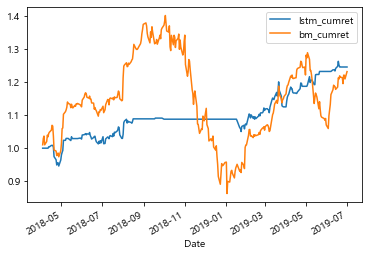

In [199]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

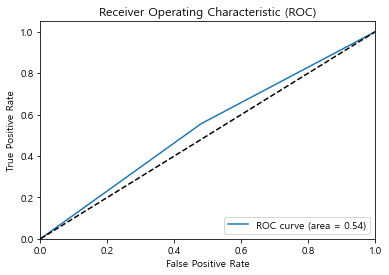

ROC AUC 값 : 0.5379


In [200]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

## 결과 

에폭 값이나(20-70) 배치 사이즈(10-15) 값은 어떻게 하더라도 정확도 범위는 항상 50정도에 수렴하였고 ROC 값 또한 50으로 수렴하는 것 같습니다.

## 종목 선정 이유: 

1. 마법공식의 따라 ROA가 높은 동시에 PER낮은 종목이라는 조건을 충족하기 위해 "규모가 크면서 수익성이 좋은" 이라는 기준으로 주식 종목을 선택하였다.
2. 당기순이익을 자산총액으로 나누어 얻어지는 수치라는 ROA 값은 자산총액이 커지면 자연스레 작아지기 마련인데 필자가 선정한 주식 종목은 자산 총액 규모가 상당한데도 불구하고 ROA 값이 상대적으로 높다고 할 수 있는 기업들을 선정했다.(애플, 아마존 등) 
3. 또한 2번 조건을 충족하면서 PER 값 또한  S&P500 평균 PER인 17.8과 차이가 얼마 나지 않는 기업들을 선별하였다.
4. 마법 공식따르기도 하였으나, 단순히 '상위 10개 기업'으로 테스트를 하지 않은 이유는, 마법 공식에 어느 정도 부합하면서, 유명한 기업을 선정하고  rnn및 lstm을 실행하는 것이 더 좋다고 생각했기 때문이다.

# 인사이트

1.roc 값은 50으로 수렴한다. 하지만, lstm의 쌓는 층을 늘린다거나 하면 성능이 개선이 될 여지가 있다. 
2.에폭 값이나(20-70) 배치 사이즈(10-15) 값은 어떻게 하더라도 정확도 범위는 항상 50정도에 수렴하였고 ROC 값 또한 50으로 수렴하였다. 이는 에폭 값봐 배치 사이즈가 정확도 범위에 영향을 거의 주지 않는다는 것을 시사한다.
3.큰 주식을 가지고 있을 때, lstm을 이용한 투자가 손실을 훨씬 더 많이 면해준다. 그래프를 보았을 때는, 상승장에서 이익을 더 못 보는것 같았지만, 하락장에서 보는 손해의 비율을 현저히 낮춰준다. 이를 통해,결과적으로 보는 수익률을 높여준다.
4.즉, rnn/lstm을 이용한 투자는 '손해를 보고 싶지 않아!'같은 생각을 가진 투자자에게 좋을 수 있다. 또한, '대형 주식위주로 오래 버티는 전략'을 구사하는 사람들에게 매우 적합하다. 이는 많은 투자의 대가들이 강조하는 것과 똑같다.
5.하지만, 그런 투자자들도, lstm 모델을 이용해서 확실히 이익을 보기 위해서는 오랜 기간 인내심을 가지고 버틸 줄 아는 덕목이 필요하다.

6.매우 간략한 인사이트:미국은 승리한다!